# Calibration

The aim is to find the slope between sensor readout (μS/cm) and concentration (g/l) for each sensor

In [1]:
bucketsize = 1.0 # calibration bucket size in liters
solution_conc = 1.0 # calibration solution concentration (g/l)

1.0

Total calibration ml solution vs sensor readout (μS/cm) for each sensor
Example from 2021:

In [2]:
calibrations = Dict(:145=>[ ## sensor 145
                             # first calibration
                          [ 0 1.1863 ## First row needs to be the background reading!
                            1 2.0325
                            3 4.0908
                            5 6.5213 
                            10 13.6905],
                          [ 0 0.2332 # low stream 1mg/l
                            1 0.9217
                            3 2.6453
                            5 4.7334
                            10 11.1907],
                          [ 0 0.1908   # low stream 10mg/l
                            10 9.7492
                            30 33.7267
                            50 56.8933
                            100 108.1295
                            150 161.2244
                            200 212.4214
                            ],
                          [ 0 1.2709   #2nd calibration lake 10mg/l
                            10 12.7645
                            30 41.9464
                            50 67.461
                            100 126.6747
                            150 183.7921
                            200 251.915
                            ],
                          [ 0 0.2014 # high stream 1mg/l
                            1 1.1545
                            3 2.8881
                            5 4.8703
                            10 10.9611
                            15 17.6196],
                          [ 0 0.212   # high stream 10mg/l
                            10 9.5296
                            30 35.3117
                            50 58.6271
                            100 112.4382
                            150 165.8554
                            200 216.3315
                            ],
                          ],
                    :309=>[## sensor 309
                          [ 0 0.7835 # high stream 1mg/l
                            1 1.7644
                            3 3.5036
                            5 5.5498
                            10 11.5504
                            15 18.1313],
                          [ 0 0.7627   # high stream 10mg/l
                            10 10.1399
                            30 35.0456
                            50 57.8871
                            100 111.7001
                            150 164.6919
                            200 213.5773
                            ],
                          ],
                    :wtw=>[## wtw
                          [ 0 4.2
                            1 6.4
                            3 10.8
                            5 15.5 
                            10 26.7],
                          [ 0 1.5 # low stream 1mg/l
                            1 3.7
                            3 7.1
                            5 12.5
                            10 23.7],
                          [ 0 1.4   # low stream 10mg/l
                            10 22.9
                            30 60.5
                            50 101.4
                            100 198
                            150 297
                            200 390
                            ],
                          [ 0 4.2 #2nd calibration lake 10mg/l
                            10 25.2
                            30 67.9
                            50 110
                            100 213
                            150 310
                            200 412
                            ],
                          [ 0 1.7 # high stream 1mg/l
                            1 4.5
                            3 8.9
                            5 13.4
                            10 24.1
                            15 34.4],
                          [ 0 1.5   # high stream 10mg/l
                            10 22
                            30 62.9
                            50 104.9
                            100 212
                            150 309
                            200 400
                            ],
                          ],
                    )

Dict{Any, Vector{Matrix{Float64}}} with 3 entries:
  145  => [[0.0 1.1863; 1.0 2.0325; … ; 5.0 6.5213; 10.0 13.6905], [0.0 0.2332;…
  309  => [[0.0 0.7835; 1.0 1.7644; … ; 10.0 11.5504; 15.0 18.1313], [0.0 0.762…
  :wtw => [[0.0 4.2; 1.0 6.4; … ; 5.0 15.5; 10.0 26.7], [0.0 1.5; 1.0 3.7; … ; …

Convert ml solution added to concentration

In [3]:
"""
Converts ml added to bucket to a concentration (g/l == kg/m^3).

Input:

- ml -- how many mililiters were added
- solution_conc -- the concentration of the calibration solution (kg/m^3 == g/l)
- bucketsize -- the size of the bucket/bottle to which the solution was added (l)

Output:

- concentration (kg/m^3 == g/l)
"""
function ml_to_concentration(ml, solution_conc, bucketsize)
    mass = ml/1e3 * solution_conc # salt mass added to bucket (g)
    return mass/bucketsize # concentration in g/l (== kg/m^3)
end

ml_to_concentration

An example, convert to concentration (g/l):

In [4]:
ml_to_concentration(calibrations[309][1][:,1], solution_conc, bucketsize)

6-element Vector{Float64}:
 0.0
 0.001
 0.003
 0.005
 0.01
 0.015

Now fit a linear function to it.  The function is pre-defined in the file helper_functions.jl with
name `fit_calibration`.

In [5]:
using NBInclude
@nbinclude("helper_functions.ipynb")

delta_cond2conc = Dict(a[1] => fit_calibration(bucketsize, solution_conc, a[2]...) for a in pairs(calibrations))

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000875±2.09e-5

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000924±1.22e-5

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000497±4.16e-6



Dict{Any, var"#1#3"{LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}, var"#fn#2"}} with 3 entries:
  145  => #1
  309  => #1
  :wtw => #1

Plot them

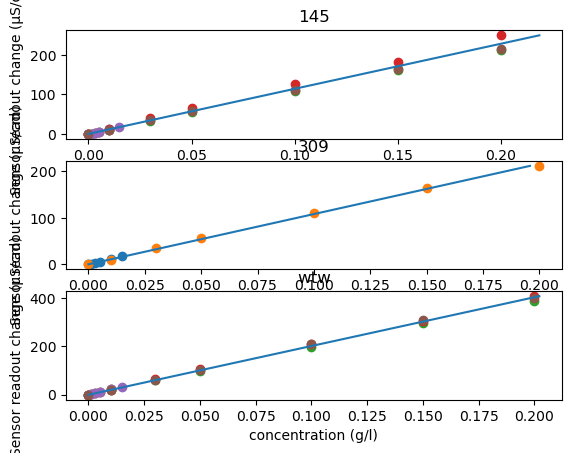

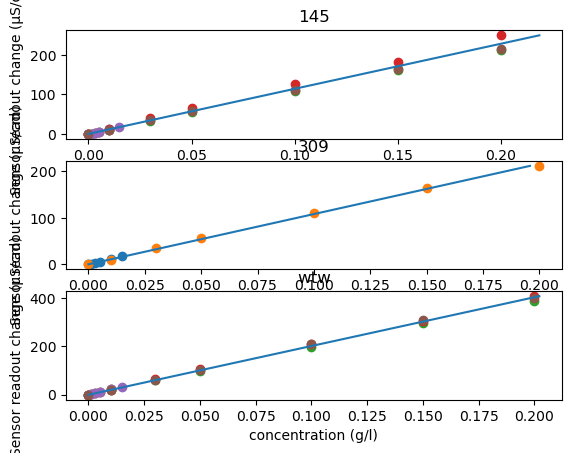

In [6]:
using PyPlot

# Note if you want a zoom-able plot opening in a new window do:
# `pygui(true)`
# to go back to in-line plots do:
pygui(false)

fig = figure()
for (i,sens) in enumerate(keys(delta_cond2conc))
    subplot(length(delta_cond2conc), 1, i)
    delta_fn = delta_cond2conc[sens]
    calis = calibrations[sens]
    # scatter plots (x,y) points
    maxreadout = 0
    for cali in calis
        conc = ml_to_concentration(cali[:,1], solution_conc, bucketsize)
        maxreadout = max(maxreadout, maximum(cali[:,2].-cali[1,2]))
        scatter(conc, cali[:,2].-cali[1,2],
                label="Calibration 1")
    end
    xlabel("concentration (g/l)")
    ylabel("Sensor readout change (μS/cm)")

    # Now plot the line of best fit:
    readouts = 0:maxreadout
    # (plot plots a line)
    plot(delta_fn(readouts), readouts, label="line of best fit")
    title(sens)
end

# mkpath("../plots")
# savefig("../plots/calibration.png") # to save this figure to a file, useful for your presentation

# return `fig` to show it in notebook
fig;

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*